In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(100)

In [2]:
# Read in data
data = pd.read_csv("Asylum_seekers_per_country_per_year_w_next_year_12_3.csv")

In [3]:
# Create current_population feature
curr_pop_list = []
for index, row in data.iterrows():
    curr_year = str(int(row.Year))
    curr_pop = row[curr_year]
    curr_pop_list.append(curr_pop)
data['current_population']=curr_pop_list

# [Not very useful] Create before_2015 feature
#data['before_2015'] = (data['Year']<2015).astype(int)

In [4]:
# Remove N/A's in Gdelt fields and current_population (these are mismatched countries, bad records anyways)
print(data.shape)
data = data.dropna(subset=['QuadClass','NuMentions'])
print(data.shape)
data = data.dropna(subset=['current_population'])
print(data.shape)
# Remove N/A's in economic data (hopefully we'll fill some of these)
data = data.dropna(subset=['Unemployment Rate',
                           'GDP Per Capita',
                           'Life expectancy',])

data.shape

(3757, 124)
(3717, 124)
(3576, 124)


(3508, 124)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


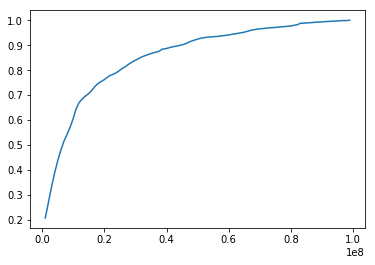

In [5]:
# S-curve of the current_population variable
num_bins = 100
counts, bin_edges = np.histogram (data.loc[data.current_population<1E8,'current_population'], bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])

In [6]:
# Feature engineering

# Log of  Economic Factors: GDP per capita, Unemployment, population
data['log_gdp_per_capita'] = np.log(data['GDP Per Capita']+0.5)
data['log_unemployment'] = np.log(data['Unemployment Rate']+0.1)
data['log_current_population'] = np.log(data['current_population']+1)

# Bucket population
# Less than 4M
data['small_pop'] = list(map(int,data['current_population']<4E6))
# Less than 40M
data['med_pop'] = list(map(int,(data['current_population']<2E7) & (data['current_population']>4E6)))
# More than 20M
data['large_pop'] = list(map(int,data['current_population']>2E7))

# Goldstein Net Counts
data['Goldstein_Net_5'] = data['Goldstein_Pos_5']-data['Goldstein_Neg_5']
data['Goldstein_Net_6'] = data['Goldstein_Pos_6']-data['Goldstein_Neg_6']
data['Goldstein_Net_7'] = data['Goldstein_Pos_7']-data['Goldstein_Neg_7']
data['Goldstein_Net_8'] = data['Goldstein_Pos_8']-data['Goldstein_Neg_8']

In [7]:
# Create y vector, 2000-2017
years = np.arange(2000,2017)
# Tried removing 2014 and 2015, but not very impactful
#years = np.delete(years,[14,15],axis=0)

y = data.loc[data.Year.isin(years),'applied_next_year']

# Log of y, the +0.5 adjustment to avoid ln(0) = -inf
y_ln = np.log(y+0.5)

# Create X feature matrix, including only the columns that we want to predict on in feature_list
feature_list = [
    'Applied during year_x',
    'med_pop',
    'large_pop',
    'GDP Per Capita',
    'log_gdp_per_capita',
    'log_unemployment',
    'Life expectancy',
    'NuMentions',
    'AvgTone',
    'Goldstein_Neg_5',
    'Goldstein_Pos_5',
    'Goldstein_Pos_7',
    'Goldstein_Pos_8',
    'Goldstein_Pos_9',
    'Event_Code_19_20',
    'Extreme_Pos_Tone_Events',
    'Extreme_Neg_Tone_Events'
    ]
X = data.loc[data.Year.isin(years),feature_list]

In [8]:
# Check for columns with N/A's and count the N/A's
for col in X:
    if X[col].isna().any():
        print(col,X[col].value_counts(dropna=False))

In [9]:
# Modeling!
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
#import xgboost as xgb

# Normalize X and y
# Note: I'm normalizing (setting mean to 0) not standardizing (setting variance to 1)
transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)

#Train_test_split, post-normalizing
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_ln, test_size=0.2)

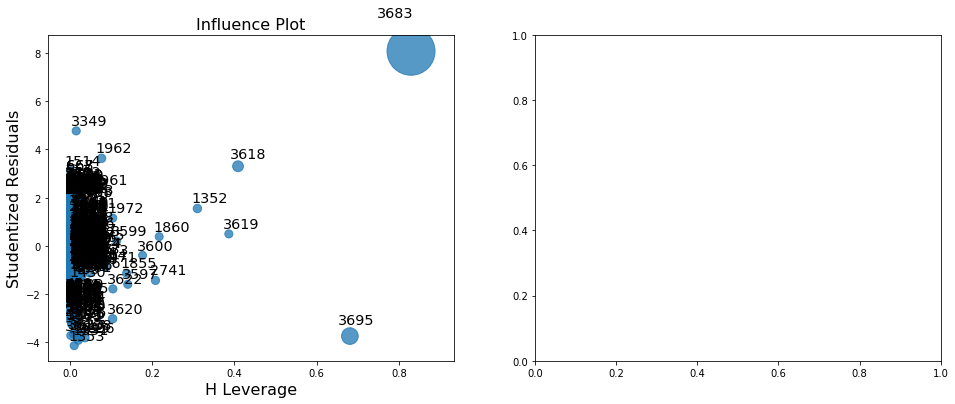

In [10]:
import statsmodels.api as sm

lm2 = sm.OLS(y_ln,X_norm)
results = lm2.fit()
#print(results.summary())

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))

ax1 = sm.graphics.influence_plot(results, ax=ax1, criterion="cooks")

influence = results.get_influence()

#influence.summary_frame()

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_norm)
print(pd.Series([variance_inflation_factor(X_vif, i) 
               for i in range(X_vif.shape[1])]))
print(X_vif[0:2,:])

0     67.011671
1      4.362437
2      2.012755
3      1.226348
4      8.750801
5      3.233123
6     41.730307
7     11.821511
8     20.491237
9     14.729866
10    29.629195
11    12.680156
12     9.786552
13     4.441858
14     2.963893
15    24.197711
16     1.741619
17     1.340954
dtype: float64
[[ 1.00000000e+00  9.99698144e-01  0.00000000e+00  3.43205111e-06
   0.00000000e+00 -2.37891655e-06  4.41239915e-06  1.91649166e-04
   1.70382839e-05  1.64936213e-05  1.36904519e-02  1.72735132e-02
   2.97558831e-03  9.36949953e-04  4.53030747e-04  1.03064495e-02
   1.27329096e-03  0.00000000e+00]
 [ 1.00000000e+00  8.94921132e-01  0.00000000e+00  1.34177119e-05
   0.00000000e+00 -9.30044919e-06  1.69085191e-05  7.55524523e-04
   6.25599830e-05  7.14146068e-05  2.88292958e-01  2.60384118e-01
   7.37705801e-02  3.59728857e-02  1.09622706e-02  2.00339857e-01
   3.47921270e-02  0.00000000e+00]]


In [12]:
# Tuning ElasticNet
import itertools

# Function for trying out models
def test_reg_tuning(reg,X_train, X_test, y_train, y_test,l1,alpha,return_reg=False):
    '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
    on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
    reg.fit(X_train,y_train)
    preds = reg.predict(X_test)
    print(l1,alpha,"r^2: ",r2_score(y_test,preds),"\n")
    if return_reg:
        return reg

# Tuning EN_reg
l_1 = [0.1,0.25,0.5,0.75,0.9]
alpha = [0.05,0.1]
for a in alpha:
    for l in l_1:    
        EN_reg = linear_model.ElasticNet(alpha=a,l1_ratio=l)
        test_reg_tuning(EN_reg,X_train, X_test, y_train, y_test,l,a)

0.1 0.05 r^2:  0.6409780272766133 

0.25 0.05 r^2:  0.6437476459780602 

0.5 0.05 r^2:  0.6479271021874522 

0.75 0.05 r^2:  0.6515590019805393 

0.9 0.05 r^2:  0.6572818229369468 

0.1 0.1 r^2:  0.6023683730706946 

0.25 0.1 r^2:  0.6071583393297639 

0.5 0.1 r^2:  0.6135365126993391 

0.75 0.1 r^2:  0.6166211472401462 

0.9 0.1 r^2:  0.6100785786031762 



In [13]:
# # Tuning GBM
# import itertools

# # Function for trying out models
# def test_reg_tuning(reg,X_train, X_test, y_train, y_test,max_depth,return_reg=False):
#     '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
#     on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
#     reg.fit(X_train,y_train)
#     preds = reg.predict(X_test)
#     print("Learning Rate: ",lr,"N_Estim: ",ne,"r^2: ",r2_score(y_test,preds),"\n")
#     if return_reg:
#         return reg

# # Tuning GB_reg
# #max_depth = [1,2,3,4,5,8,10]
# learning_rate = [0.15,0.1,0.05,0.01,0.005,0.001]
# n_estimators = [100,250,500,750,1000,1250,1500,1750]

# for lr in learning_rate:
#     for ne in n_estimators:
#         GB_reg = ensemble.GradientBoostingRegressor(learning_rate=lr,n_estimators=ne,max_depth=4)
#         test_reg_tuning(GB_reg,X_train, X_test, y_train, y_test,lr,ne)

In [14]:
# Function for trying out models
def test_reg(reg,X_train, X_test, y_train, y_test,return_reg=False):
    '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
    on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
    reg.fit(X_train,y_train)
    train_preds = reg.predict(X_train)
    preds = reg.predict(X_test)
    print(reg,"\nTrain r^2: ",r2_score(y_train,train_preds),"\nTest r^2: ",r2_score(y_test,preds),"\n")
    if return_reg:
        return reg

# Instantiate the regressors
LR_reg = linear_model.LinearRegression()
EN_reg = linear_model.ElasticNet(l1_ratio=0.5,alpha=0.05)
SV_reg = svm.SVR(C=1)
DT_reg = tree.DecisionTreeRegressor()
RF_reg = ensemble.RandomForestRegressor(n_estimators=100)
GB_reg = ensemble.GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=4)
#XGB_reg = xgb.XGBRegressor(eta= .01, objective='reg:squarederror')

# Train and test all models with default settings
for model in [LR_reg,EN_reg,SV_reg,DT_reg,RF_reg,GB_reg]:  #,XGB_reg]:
    test_reg(model,X_train, X_test, y_train, y_test) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
Train r^2:  0.7585487262518262 
Test r^2:  0.6653880108053086 

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
Train r^2:  0.6896562188568996 
Test r^2:  0.6479271021874522 



//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) 
Train r^2:  0.7179594601153606 
Test r^2:  0.6847575571884175 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') 
Train r^2:  0.999999999969831 
Test r^2:  0.8731958452250168 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
           

In [15]:
# Random Forest provides feature_importance...not rock solid, but useful for some context
GB_reg.fit(X_train,y_train)

for name,imp in zip(X.columns,GB_reg.feature_importances_):
    print("{}: {:2.2}".format(name,imp))

Applied during year_x: 0.8
med_pop: 0.0015
large_pop: 0.0018
GDP Per Capita: 0.015
log_gdp_per_capita: 0.096
log_unemployment: 0.0061
Life expectancy: 0.016
NuMentions: 0.031
AvgTone: 0.0097
Goldstein_Neg_5: 0.0037
Goldstein_Pos_5: 0.00076
Goldstein_Pos_7: 0.002
Goldstein_Pos_8: 0.0021
Goldstein_Pos_9: 0.002
Event_Code_19_20: 0.0045
Extreme_Pos_Tone_Events: 0.0035
Extreme_Neg_Tone_Events: 0.00039


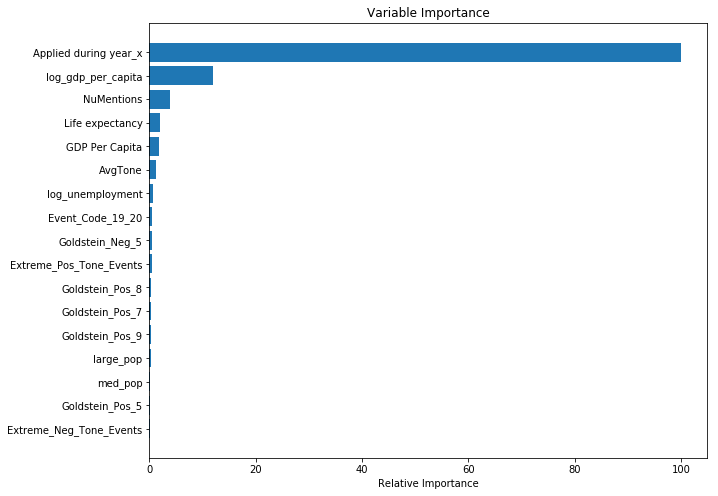

In [27]:
plt.figure(num=None, figsize=(10, 8))
# Plot feature importance
feature_importance = GB_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [17]:
'''# Hyperparameter tuning for the RandomForest model
# NOTE: This still isn't working very well.  I'm yet to get a model that beats the defaults.
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = ensemble.RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Make preds and calculate R^2
RF_optimized = best_grid = grid_search.best_estimator_
preds = best_grid.predict(X_test)
print(best_grid,"\nr^2: ",r2_score(y_test,preds),"\n")'''

'# Hyperparameter tuning for the RandomForest model\n# NOTE: This still isn\'t working very well.  I\'m yet to get a model that beats the defaults.\nfrom sklearn.model_selection import GridSearchCV\n# Create the parameter grid based on the results of random search \nparam_grid = {\n    \'bootstrap\': [True],\n    \'max_depth\': [80, 90, 100, 110],\n    \'max_features\': [2, 3],\n    \'min_samples_leaf\': [3, 4, 5],\n    \'min_samples_split\': [8, 10, 12],\n    \'n_estimators\': [100, 200, 300, 1000]\n}\n# Create a based model\nrf = ensemble.RandomForestRegressor()\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid, \n                          cv = 3, n_jobs = -1, verbose = 2)\n\n# Fit the grid search to the data\ngrid_search.fit(X_train, y_train)\n\n# Make preds and calculate R^2\nRF_optimized = best_grid = grid_search.best_estimator_\npreds = best_grid.predict(X_test)\nprint(best_grid,"\nr^2: ",r2_score(y_test,preds),"\n")'

## Test Data: 2018

In [18]:
# Dependent Variable
y_17 = data.loc[data.Year==2017,'applied_next_year']

y_ln_17 = np.log(y_17+0.5)

# Feature Matrix
X_17 = data.loc[data.Year==2017,feature_list]

transformer_17 = Normalizer().fit(X_17)
X_norm_17 = transformer_17.transform(X_17)


In [19]:
# Predict on 2017
def pred_2017(reg,X_17, y_17):
    '''Takes a trained model and the final test X and test y, in this case 2017 data.'''
    preds = reg.predict(X_17)

    print(reg,"\nr^2: ",r2_score(y_17,preds),"\n")

# Run with best performing model
for model in [LR_reg,EN_reg,SV_reg,DT_reg,RF_reg,GB_reg]:  #,XGB_reg]:
    pred_2017(model,X_norm_17,y_ln_17)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
r^2:  0.7023114258332259 

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
r^2:  0.6340805132997012 

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) 
r^2:  0.6651422207573996 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') 
r^2:  0.9123223882918343 

RandomForestRegressor(bootstrap=True, criterion='mse', max_dept

### Baseline

In [20]:
# Baseline for 2017
X_baseline = X_norm[:,:1]
X_baseline_17 = X_norm_17[:,:1]

# Instantiate the regressors
LR_reg_baseline = linear_model.LinearRegression()
EN_reg_baseline = linear_model.ElasticNet(l1_ratio=0.25,alpha=0.05)
SV_reg_baseline = svm.SVR()
DT_reg_baseline = tree.DecisionTreeRegressor()
RF_reg_baseline = ensemble.RandomForestRegressor(n_estimators=100)
GB_reg_baseline = ensemble.GradientBoostingRegressor()
#XGB_reg_baseline = xgb.XGBRegressor(eta= .01, objective='reg:squarederror')
# Train and test all models with default settings
for model in [LR_reg_baseline,EN_reg_baseline,SV_reg_baseline,DT_reg_baseline,RF_reg_baseline,GB_reg_baseline]:  #,XGB_reg_baseline]:
    test_reg(model,X_baseline, X_baseline_17, y_ln, y_ln_17) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
Train r^2:  0.5162068606667457 
Test r^2:  0.4189584680642576 

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.25,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
Train r^2:  0.47984793006223225 
Test r^2:  0.366932585464941 



//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) 
Train r^2:  0.6426322694772204 
Test r^2:  0.5822726040357835 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') 
Train r^2:  0.9956447076375664 
Test r^2:  0.5449137124293766 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
        

In [21]:
X_baseline

array([[0.99969814],
       [0.89492113],
       [0.77241951],
       ...,
       [0.16082396],
       [0.        ],
       [0.        ]])

//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0.98, 'Skew correction charts for Population, Unemployment, and GDP')

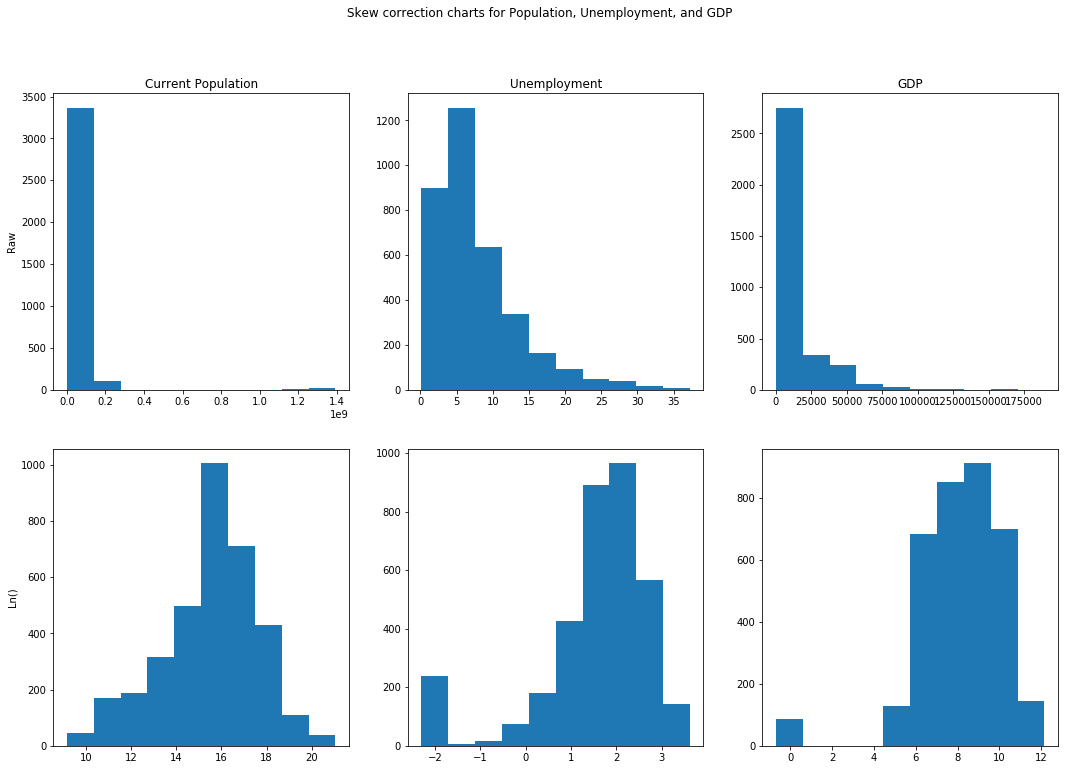

In [22]:
# Skew correction charts for Population, Unemployment, and GDP

fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharey=False)
axs[0,0].hist(data['current_population'])
axs[0,1].hist(data['Unemployment (Clean)'])
axs[0,2].hist(data['GDP Per Capita (Clean)'])
axs[1,0].hist(data['log_current_population'])
axs[1,1].hist(data['log_unemployment'])
axs[1,2].hist(data['log_gdp_per_capita'])
axs[0,0].set_title("Current Population")
axs[0,1].set_title("Unemployment")
axs[0,2].set_title("GDP")
axs[0,0].set_ylabel("Raw")
axs[1,0].set_ylabel("Ln()")
fig.suptitle("Skew correction charts for Population, Unemployment, and GDP")

Text(0, 0.5, 'Histogram Number of country-years')

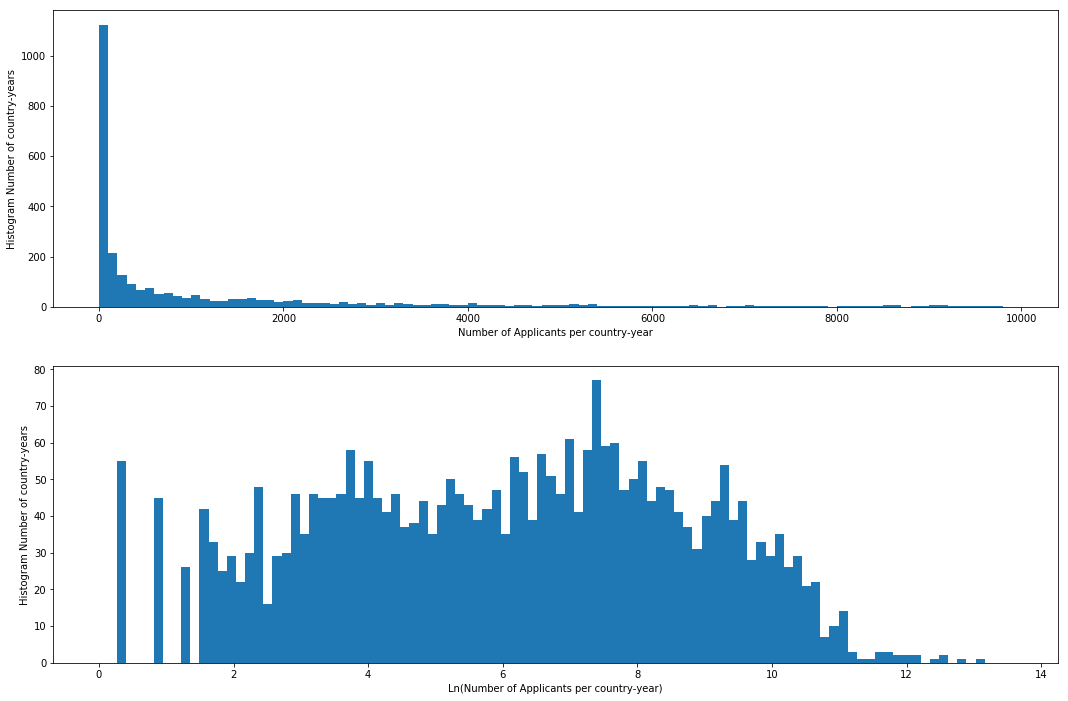

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12), sharey=False)

# Plot the histogram of applicant counts per country-year
bin_arr = np.arange(0,10000,100)
bin_arr_ln = np.arange(0,y_ln.max(),y_ln.max()/100)

axs[0].hist(y,bins=bin_arr)
axs[0].set_xlabel("Number of Applicants per country-year")
axs[0].set_ylabel("Histogram Number of country-years")

axs[1].hist(y_ln,bins=bin_arr_ln)
axs[1].set_xlabel("Ln(Number of Applicants per country-year)")
axs[1].set_ylabel("Histogram Number of country-years")

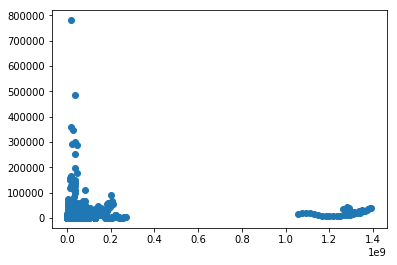

In [24]:
# Applicants - population scatter
plt.scatter(data['current_population'],data['Applied during year_x'])

In [25]:
X_17.columns

Index(['Applied during year_x', 'med_pop', 'large_pop', 'GDP Per Capita',
       'log_gdp_per_capita', 'log_unemployment', 'Life expectancy',
       'NuMentions', 'AvgTone', 'Goldstein_Neg_5', 'Goldstein_Pos_5',
       'Goldstein_Pos_7', 'Goldstein_Pos_8', 'Goldstein_Pos_9',
       'Event_Code_19_20', 'Extreme_Pos_Tone_Events',
       'Extreme_Neg_Tone_Events'],
      dtype='object')